# Download ATL06 Data from NSIDC server
Should work with any random area (either shapefile or coordinates of box)  
Make changes to the codes following number 1 to 6 to fulfill your requirements  

## Inputs:
    - define the folder to download and process files
    - shapefile with defined projection (can be be in any system)
    - or coordinates of box [lowerleft, upper right] or coordinates in lat/lon coordinate system

In [1]:
import math
import os
import shutil
import time
from datetime import timedelta

#import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import geopandas as gpd
from shapely.geometry import Point, Polygon #, mapping
#from shapely.geometry.polygon import orient
from statistics import mean
import h5py
import json
import zipfile
import io

import requests
import getpass
import socket
#from requests.auth import HTTPBasicAuth
import logging

```If you get any error, that means some packages are missing, most likely geopandas and h5py   ```
Install them from Anaconda navigator  
or manually from command prompt/terminal as such  
- conda install geopandas
- conda install h5py

If there is some error in installation, it means package not available in default anaconda package. use the following command  
- conda install h5py -c conda-forge


## 1. Choose output Directory

In [2]:
# Housekeeping: This is where files will be downloaded and all ouputs saved
# icesat2_path = 'D:/wspace/icesat2/problematic' #CHANGE THIS
icesat2_path = 'test_data/test1' #CHANGE THIS
if not os.path.exists(icesat2_path):
    print(f'Create Output Directory : {icesat2_path}')
    os.makedirs(icesat2_path) #exist_ok=True to prevent complaint if directory exist
    os.mkdir(f'{icesat2_path}/downloads')

## 2. Either give a full path to shapefile or replace the corner coordinates below

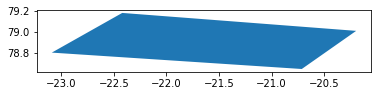

In [3]:
# Either give the full path to outline as polygon shapefile
shp = 'gis/aoi_greenland/aoi_for_icesat.shp' #insert full path to shapefile if you have one
if shp:
    gdf = gpd.read_file(shp)
    #gdf = get_rema_strip_polygon(strip_folder, 'arctic')
    # Convert to Latlong
    gdf = gdf.to_crs({'init': 'epsg:4326'})
else:
    print('No shapefile give, replace the lower-left and upper-right coordinates to define the box')
    # Or Digitize the outline of shapefile (replace the coordinates for your area here)
    x0 = -147.5
    y0 = 64.2
    x1 = -146.5
    y1 = 65.2
#     x0 = -20.75
#     y0 = 78.80
#     x1 = -21.34
#     y1 = 78.89
    geom = Polygon([(x0, y0), (x1, y0), (x1, y1), (x0, y1)])
    gdf = gpd.GeoSeries(geom, crs='epsg:4326')
# Save for future use (but not required for script to work)    
gdf.to_file(f'{icesat2_path}/outline.shp')
shp_json = gdf.to_json() #use json as shapefile, or kml too, shp file not yet tried
gdf.plot()

In [7]:
import hvplot
import hvplot.pandas
import geoviews as gv

# # Since geoseries can't be plotted by holoviews, convert to geodataframe and define the geometry
# gdf1 = gpd.GeoDataFrame(gdf)
# gdf1.columns = ['geometry']

base = gv.tile_sources.ESRI

strips = gdf.hvplot(geo=True, alpha=0.5, c=None)
base * strips

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]

In [8]:
#% To use Bounding Box for subsetting
bounding_box = ','.join(map(str, list(gdf.total_bounds)))
bounding_box
# Bounding box subsetting (bbox) in same format as bounding_box
#bbox = bounding_box #not used in post

'-23.08882806802458,78.64732924954261,-20.19764020101351,79.17986902177026'

## 3. Temporal Subsetting
Replace Start and End date time in the following string format by replacement

In [9]:
start_date = '2018-10-14' #yyyy-MM-dd format '2018-10-14' #'2019-04-01' # start of ATL06 2018/10/14
start_time = '00:00:00' #HH:mm:ss format
end_date = '2019-12-31' #'2019-09-30'
end_time = '23:59:59'
temporal = start_date + 'T' + start_time + 'Z' + ',' + end_date + 'T' + end_time + 'Z'
print(temporal)

2018-10-14T00:00:00Z,2019-12-31T23:59:59Z


# No need to change anything below except item 4 (your authentication)
But observe the size of our ouputs and modify spatial/temporal extent accordingly

In [10]:
# Define the Granules search parameters the NSIDC Server
short_name = 'ATL06'
latest_version = '002' #directly without using the cmr search to simplify the script
search_params = {
        'short_name': short_name,
        'version': latest_version,
        'temporal': temporal,
        'page_size': 100,
        'page_num': 1,
        'bounding_box': bounding_box
        }

# Query number of granules using our (paging over results)

In [11]:
granule_search_url = 'https://cmr.earthdata.nasa.gov/search/granules'
headers={'Accept': 'application/json'} #if not defined in first block to get the token
granules = []
count = 0
while True:
    print(count)
    response = requests.get(granule_search_url, params=search_params, headers=headers)
    results = json.loads(response.content)
    if len(results['feed']['entry']) == 0:
        # Out of results, so break out of loop
        break
    # Collect results and increment page_num
    granules.extend(results['feed']['entry'])
    search_params['page_num'] += 1
    count +=1
# Get number of granules over my area and time of interest
print(f'Number of Granules = {len(granules)}')

0
Number of Granules = 0


In [25]:
granule_sizes = [float(granule['granule_size']) for granule in granules]
print('Total Size of Granules: ', sum(granule_sizes), 'MB')

Total Size of Granules:  0 MB


## 4. Choose the authentication mechanism
username, password, and the token (by running the token code below (item 5)

In [12]:
# Query service capability URL : seems only to see what service is availabe
from xml.etree import ElementTree as ET
capability_url = f'https://n5eil02u.ecs.nsidc.org/egi/capabilities/{short_name}.{latest_version}.xml'
#print(capability_url)

#Create session to store cookie and pass credentials to capabilities url
email=''
try:
    from icesat2_search_and_download_ATL import get_api_key
    uid, pswd, token = get_api_key()
    print("Success getting authentication")
except:
    # Input explicitly here
    uid = ''#'Replace with your username'
    email = '' #if you provide your email, you will receive email for every order; 
    pswd = ''#'Repalce with your password'


Success getting authentication


## 5. Request token from Common Metadata Repository using Earthdata credentials
Run this block of code only once, note the printed token, and replace the token in the next block of code

In [14]:
#pswd = getpass.getpass('Earthdata Login password: ') #B2f
# token = '' #'Replace this with the output above' 

session = requests.session()
s = session.get(capability_url)

response = session.get(s.url,auth=(uid,pswd))

In [15]:
coverage = ''
# Temporal subsetting KVP
timevar = temporal # this seemed to work as well, when used temporal below directly
# Request data from the NSIDC data access API.
'''the API is structured as a URL with a base plus individual key-value-pairs (KVPs) separated by ‘&’. 
The base URL of the NSIDC API is: '''
base_url = 'https://n5eil02u.ecs.nsidc.org/egi/request' ##Set NSIDC data access base URL

# Set number of granules requested per order, which we will initially set to 10.
page_size = 10
#Determine number of pages basd on page_size and total granules. Loop requests by this value
page_num = math.ceil(len(granules)/page_size)
#Set request mode. 
request_mode = 'async' #with synchronous, there is possibility of timeout errors

#Create config dictionary
config_params = {
    'request_mode': request_mode, 
    'page_size': page_size,  
    'token': token, 
    'email': email,   
}

#timevar replaced with temporal: and it seems to work fine
custom_params = {
    'time': temporal,
    'Coverage': coverage, 
    }
# Creating final request parameter dictionary with search, config, and customization parameters.
subset_request_params = {**search_params, **config_params, **custom_params}

# This block of code will download the data  
- may take a few minutes
- you will receive email if you provided one
- may print some error: these are mostly system error on NSIDC part (at least thats what I learned for Any at the AGU meeting)

In [13]:
#%% Choose method to make a request
method = 'post' #'get' 'post'
for i in range(page_num):
    page_val = i + 1
    print('Order: ', page_val)
    if method == 'post':
        # We are sending shapefile (in KML format) to the server
        subset_request_params.update( {'page_num': page_val})
        # Post polygon to API endpoint for polygon subsetting to subset based on original, non-simplified KML file
        #shape_post = {'shapefile': open(kml_filepath, 'rb')}
        shape_post = {'shapefile': shp_json}
        
        request = session.post(base_url, params=subset_request_params, files=shape_post, auth=(uid,pswd))

    # Raise bad request: Loop will stop for bad response code.
    request.raise_for_status()
    #print('Order request URL: ', request.url)
    esir_root = ET.fromstring(request.content)
    #print('Order request response XML content: ', request.content)

    #Look up order ID
    orderlist = []
    for order in esir_root.findall("./order/"):
        orderlist.append(order.text)
    orderID = orderlist[0]
    print('order ID: ', orderID)

    #Create status URL
    statusURL = base_url + '/' + orderID
    print('status URL: ', statusURL)

    #Find order status
    request_response = session.get(statusURL)
    #logging.info(f'Order Status HTTP response: {request_response.status_code}')

    # Raise bad request: Loop will stop for bad response code.
    request_response.raise_for_status()
    request_root = ET.fromstring(request_response.content)
    statuslist = []
    for status in request_root.findall("./requestStatus/"):
        statuslist.append(status.text)
    status = statuslist[0]
    print('Data request ', page_val, ' is submitting...')
    print('Initial request status is ', status)

    #Continue loop while request is still processing
    while status == 'pending' or status == 'processing': 
        print('Status is not complete. Trying again.')
        sleep_sec = 10
        time.sleep(sleep_sec)
        loop_response = session.get(statusURL)
        # Raise bad request: Loop will stop for bad response code.
        loop_response.raise_for_status()
        loop_root = ET.fromstring(loop_response.content)
        #find status
        statuslist = []
        for status in loop_root.findall("./requestStatus/"):
            statuslist.append(status.text)
        status = statuslist[0]
        print('Retry request status is: ', status)
        if status == 'pending' or status == 'processing':
            continue
    #Order can either complete, complete_with_errors, or fail:
    # Provide complete_with_errors error message:
    if status == 'complete_with_errors' or status == 'failed':
        messagelist = []
        for message in loop_root.findall("./processInfo/"):
            messagelist.append(message.text)
        logging.error(f'error messages: {messagelist}')
        #pprint.pprint(messagelist)

    # Download zipped order if status is complete or complete_with_errors
    #'https://n5eil02u.ecs.nsidc.org/esir/5000000402535/166238470/
    #processed_ATL06_20181102070512_05290110_002_01.h5
    if status == 'complete' or status == 'complete_with_errors':
        downloadURL = 'https://n5eil02u.ecs.nsidc.org/esir/' + orderID + '.zip'
        print('Beginning download of zipped output...')
        zip_response = session.get(downloadURL)
        # Raise bad request: Loop will stop for bad response code.
        zip_response.raise_for_status()
        with zipfile.ZipFile(io.BytesIO(zip_response.content)) as z:
            z.extractall(f'{icesat2_path}/downloads')
        print('Data request', page_val, 'is complete.')
    else: print('Request failed.')

# Further processing
a. Extract the zip files  
b. Parse the HDF files

In [14]:
## Extract the downloaded HDF files and cleanup the downloaded folder
def move_files_from_order(icesat2_path):
    ''' Extract files from downloaded subfoder [ie one by orderid] 
        and move all hdf files in one location
    '''
    hdf_path = icesat2_path
    for root, dirs, files in os.walk(f'{icesat2_path}/downloads', topdown=False):
        for f in files:
            if f.endswith('h5'):
                try:
                    shutil.move(os.path.join(root, f), hdf_path)
                except:
                    logging.error("Extraction Error (SHUTIL): perhaps file already exist")
    #os.rmdir(f'{icesat2_path}/downloads') #for empty
    shutil.rmtree(f'{icesat2_path}/downloads')
    
# Cleanup : move the hdf files to base folder and deleted the "downloads" folder
move_files_from_order(icesat2_path)


## Convert/Parse the HDF files to csv file/shapefile

In [10]:
files = os.listdir(icesat2_path)
hdf_files = [f for f in files if f.endswith('.h5')]
hdf_files

['processed_ATL06_20181017053005_02840105_002_01.h5',
 'processed_ATL06_20181026153716_04280103_002_01.h5',
 'processed_ATL06_20181115040622_07260105_002_01.h5',
 'processed_ATL06_20181119035757_07870105_002_01.h5',
 'processed_ATL06_20181124141317_08700103_002_01.h5',
 'processed_ATL06_20181128140455_09310103_002_01.h5',
 'processed_ATL06_20181218023352_12290105_002_01.h5',
 'processed_ATL06_20181227124101_13730103_002_01.h5',
 'processed_ATL06_20190116010949_02840205_002_01.h5',
 'processed_ATL06_20190120010133_03450205_002_01.h5',
 'processed_ATL06_20190217233746_07870205_002_01.h5',
 'processed_ATL06_20190318221349_12290205_002_01.h5',
 'processed_ATL06_20190328082055_13730203_002_01.h5',
 'processed_ATL06_20190416204947_02840305_002_01.h5',
 'processed_ATL06_20190426065655_04280303_002_01.h5',
 'processed_ATL06_20190515192547_07260305_002_01.h5',
 'processed_ATL06_20190519191724_07870305_002_01.h5',
 'processed_ATL06_20190525053252_08700303_002_01.h5',
 'processed_ATL06_2019052905

In [12]:
#%% To Parse hdf file and convert csv and shapefile for analysis/visualization
from astropy.time import Time
def gps2dyr(time, offset = 0):
    """ Converte GPS time to decimal years. Helper function"""
    time = time + offset
    gps_time = Time(time, format='gps')#.decimalyear
    iso_time = Time(gps_time, format='iso')
    iso_time = iso_time.value
    # Conver to pandas datetime [not sure if it is utc]
    dt = pd.to_datetime(iso_time)
    return dt

def read_atl06(icesat2_path):
    """ Read 1 ATL06 file and output 6 reduced files.     
        Extract variables of interest and separate the ATL06 file 
        into each beam (ground track) and ascending/descending orbits."""
    files = os.listdir(icesat2_path)
    hdf_files = [f for f in files if f.endswith('.h5')]
    for f in hdf_files:
        hdf_path = f'{icesat2_path}/{f}'
        res_dict = {}
        meta_dict = {} #These will hold metadata required for scalars per ground-track
        group = ['gt1l', 'gt1r', 'gt2l', 'gt2r', 'gt3l', 'gt3r']
        qual_str_count = ''
        # Loop trough beams
        # Perhaps read file first, then loop through groups; should be faster
        with h5py.File(hdf_path, 'r') as fi:
            # subset group based on data
            group = [g for g in list(fi.keys()) if g in group]
            for k,g in enumerate(group):
                try:
                    # 1) Read in data for a single beam #
                    lat = fi[f'/{g}/land_ice_segments/latitude'][:]
                    lon = fi[f'/{g}/land_ice_segments/longitude'][:]
                    h_li = fi[f'/{g}/land_ice_segments/h_li'][:] #nan
                    #s_li = fi[f'/{g}/land_ice_segments/h_li_sigma'][:] #nan
                    t_dt = fi[f'/{g}/land_ice_segments/delta_time'][:]
                    q_flag = fi[f'/{g}/land_ice_segments/atl06_quality_summary'][:]
                    t_ref = fi['/ancillary_data/atlas_sdp_gps_epoch'][:] #scalar 1 value; required for offset
                    
                    meta_dict['t_ref'] = t_ref #dictionary of metadata (will be used in future to investigate data)
                    # 2) Make Pandas dataframe
                    df = pd.DataFrame({'lon':lon, 'lat':lat, 'h_li': h_li, 'q_flag':q_flag, 't_dt':t_dt})
                    #Convert GPS time to actual time using function
                    df['t_dt'] = df['t_dt'].apply(gps2dyr, offset=t_ref[0])
                    # Fill Nans for na-data and drop
                    df.loc[df.h_li>3e38, 'h_li'] = np.nan
                    df = df.dropna()
                    all_points = len(df)
                    df = df[df.q_flag==0] #select only flags of zero (good values) can be empty sometimes
                    good_quality_points = len(df) #len(df[df.q_flag==0])
                    qual_str_count = qual_str_count + f'{g}={good_quality_points}/{all_points}; '
                    if len(df)>0:
                        # Assemble ground track into a dictionary, later we convert to csv and shp through df
                        res_dict[g] = df
                except:
                    # Most like this error is due to empty dataframe 
                    # may not exist anymore since we are no dropping the bad quality data
                    print(f'\tException in reading hdf group (ground track), df length = {len(df)}')
            #----------------------------------------------------------------------------------------------
            # Now that ATL06 data from separate ground tracks are in one dict, merge it to df and save to csv/shp
            if len(res_dict)>0:
                print(f'\tGood/Total Points: {qual_str_count}   Total GTs = {len(res_dict)}')
                # To guard againt empty result dictionary created with no icesat2 passing the quality control above
                # 1. Combine Dataframes for each of 6 ground-tracks into single Dataframe
                count = 0
                for k in res_dict.keys():
                    # k = 'gt1l', 'gt1r' etc
                    if count == 0:
                        df = res_dict[k]
                        df['strip'] = k
                        count += 1
                    else:
                        df1 = res_dict[k]
                        df1['strip'] = k
                        df = pd.concat([df, df1], axis=0)
                # Log the time range of icesat2 data (could be useful for understanding why some data is large)
                # This may be creating exception when empty
                time_range = df.t_dt.max() - df.t_dt.min()
                print(f"\tRows = {len(df)} \t Time Range = {time_range.total_seconds()} seconds")
                # Choose filename for csv and shapefile
                atl_fname = os.path.splitext(hdf_path)[0].split('/')[-1]
                #df = df[df.q_flag==0] # Already done above for each ground track
                df.to_csv(f'{icesat2_path}/{atl_fname}.csv', index=False)
                
                # 2. Convert to Geopandas
                df['coord'] = df[['lon', 'lat']].apply(lambda x: Point(x), axis=1)
                gdf = gpd.GeoDataFrame(df[['t_dt', 'h_li', 'q_flag', 'strip', 'coord']], geometry='coord')
                gdf['t_dt'] = gdf['t_dt'].dt.strftime('%Y-%m-%d %H:%M:%S.%f') #To prevent DriverSupportError: ESRI Shapefile does not support datetime fields
                gdf.crs = {'init': 'epsg:4326'} #not yet verified or checked with what ICESAT-2 metadata provides
                gdf.to_file(f'{icesat2_path}/{atl_fname}.shp')
            else:
                print(f"\tNo good quality Ground Track in this HDF file; csv or shp not created")


In [13]:
# Call the function defined above to parse hdf files
read_atl06(icesat2_path)

Now you can analyze the data in any software of your choice  
QGIS would be a good start but you can also use python, R, matlab